# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
!pip install phik
!pip install --upgrade scikit-learn
!pip install shap

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

import phik
import shap

import os

# Задача №1: предсказание уровня удовлетворённости сотрудника

## Загрузка данных

In [3]:
data_path = '/datasets/train_job_satisfaction_rate.csv'

if os.path.exists(data_path):
    train_job_satisfaction_rate = pd.read_csv(data_path)
else:
    print('Файл не найден!')
    
data_path = '/datasets/test_features.csv'
    
if os.path.exists(data_path):
    test_features = pd.read_csv(data_path)
else:
    print('Файл не найден!')
    
data_path = '/datasets/test_target_job_satisfaction_rate.csv'
    
if os.path.exists(data_path):
    test_target_job_satisfaction_rate = pd.read_csv(data_path)
else:
    print('Файл не найден!')

## Предобработка данных

In [4]:
display(train_job_satisfaction_rate.info())
display(train_job_satisfaction_rate.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
display(test_features.info())
display(test_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
display(test_target_job_satisfaction_rate.info())
display(test_target_job_satisfaction_rate.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [7]:
print(train_job_satisfaction_rate.columns)
print(test_features.columns)
print(test_target_job_satisfaction_rate.columns)

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')
Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')
Index(['id', 'job_satisfaction_rate'], dtype='object')


В данных обнаружено незначительное количество пропусков. Пропуски находятся в важных категориальных колонках, без которых данные значительно теряют в ценности, поэтому в пайплайне будем их заполнять при помощи SimpleInputer. Все типы данных соответствуют истине.

Проверим наличие дубликатов.

In [8]:
print(train_job_satisfaction_rate.duplicated().sum())
print(test_features.duplicated().sum())
print(test_target_job_satisfaction_rate.duplicated().sum())

0
0
0


Явных дубликатов нет. Проверим наличие неявных.

In [9]:
print(train_job_satisfaction_rate['dept'].unique())
print(train_job_satisfaction_rate['level'].unique())
print(train_job_satisfaction_rate['workload'].unique())
print(train_job_satisfaction_rate['last_year_promo'].unique())
print(train_job_satisfaction_rate['last_year_violations'].unique(), '\n')

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes'] 



In [10]:
print(test_features['dept'].unique())
print(test_features['level'].unique())
print(test_features['workload'].unique())
print(test_features['last_year_promo'].unique())
print(test_features['last_year_violations'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


В данных обнаружены необработанные пропуски и опечатки. Обработаем их.

In [11]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan

train_job_satisfaction_rate.loc[train_job_satisfaction_rate['level'] == 'sinior', 'level'] = 'senior'
test_features.loc[test_features['level'] == 'sinior', 'level'] = 'senior'

In [12]:
print(test_features['dept'].unique())
print(test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


In [13]:
print(train_job_satisfaction_rate.duplicated().sum())
print(test_features.duplicated().sum())
print(test_target_job_satisfaction_rate.duplicated().sum())

0
0
0


Дубликатов нет. Дальнейшая предобработка будет выполнена в пайплайне.

## Исследовательский анализ данных

In [14]:
display(train_job_satisfaction_rate.info())
display(train_job_satisfaction_rate.drop('id', axis=1).describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


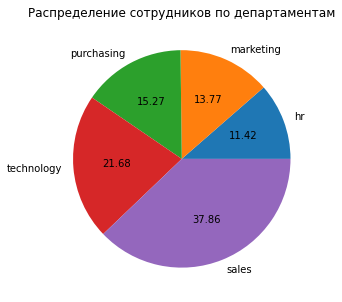

In [15]:
analysis_chart = train_job_satisfaction_rate.groupby('dept')['id'].count().sort_values().plot(
    y = 'dept',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по департаментам',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак dept при помощи OneHotEncoder. Пропуски заполняем при помощи SimpleInputer. Больше всего сотрудников в отделе продаж, меньше всего - в отделе управления персоналом.

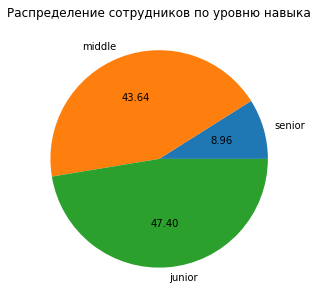

In [16]:
analysis_chart = train_job_satisfaction_rate.groupby('level')['id'].count().sort_values().plot(
    y = 'level',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню навыка',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак level при помощи OrdinalEncoder. Пропуски заполняем при помощи SimpleInputer. Подавляющее большинство сотрудников имеют уровень "junior" или "middle".

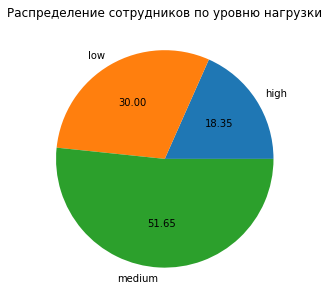

In [17]:
analysis_chart = train_job_satisfaction_rate.groupby('workload')['id'].count().sort_values().plot(
    y = 'workload',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню нагрузки',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак workload при помощи OrdinalEncoder. У большинства сотрудников средний уровень нагрузки.

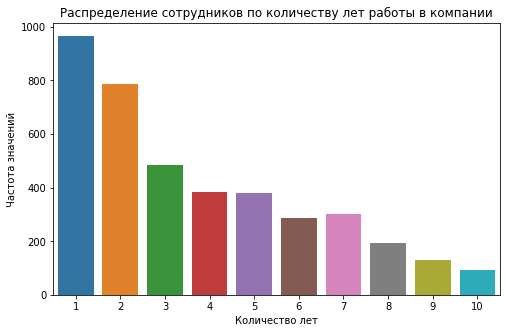

In [18]:
plt.figure(figsize=(8, 5))

analysis_chart = sns.countplot(x = train_job_satisfaction_rate['employment_years'])

analysis_chart.set_title("Распределение сотрудников по количеству лет работы в компании")
analysis_chart.set_xlabel("Количество лет")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

График распределения сотрудников по количеству лет на работе напоминает график распределения Пуассона.

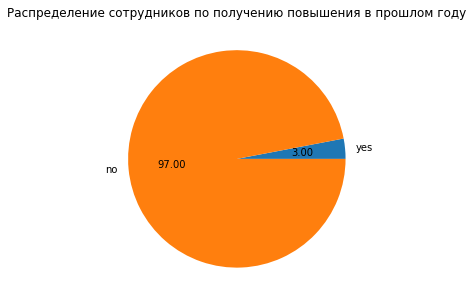

In [19]:
analysis_chart = train_job_satisfaction_rate.groupby('last_year_promo')['id'].count().sort_values().plot(
    y = 'last_year_promo',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по получению повышения в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак при помощи OrdinalEncoder.

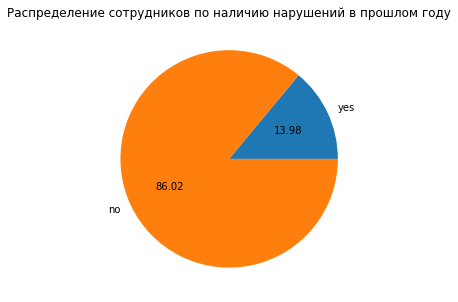

In [20]:
analysis_chart = train_job_satisfaction_rate.groupby('last_year_violations')['id'].count().sort_values().plot(
    y = 'last_year_violations',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по наличию нарушений в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак при помощи OrdinalEncoder.

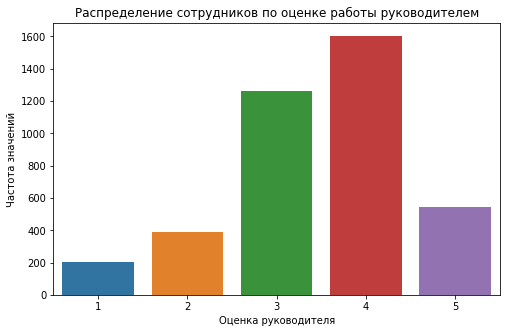

In [21]:
plt.figure(figsize=(8, 5))

analysis_chart = sns.countplot(x = train_job_satisfaction_rate['supervisor_evaluation'])

analysis_chart.set_title("Распределение сотрудников по оценке работы руководителем")
analysis_chart.set_xlabel("Оценка руководителя")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

Признак распределён неравномерно.

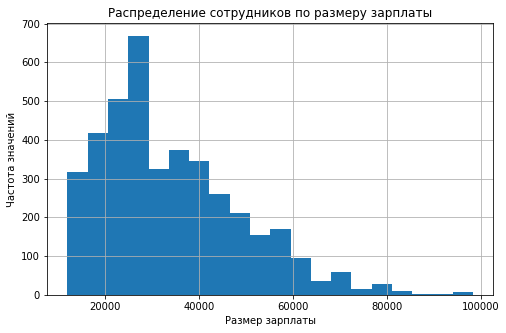

In [22]:
analysis_chart = train_job_satisfaction_rate['salary'].plot(
    y = 'salary',
    kind = 'hist',
    bins = 20,
    grid = True,
    figsize = (8, 5),
    title = 'Распределение сотрудников по размеру зарплаты',
)
analysis_chart.set_xlabel("Размер зарплаты")
analysis_chart.set_ylabel("Частота значений");

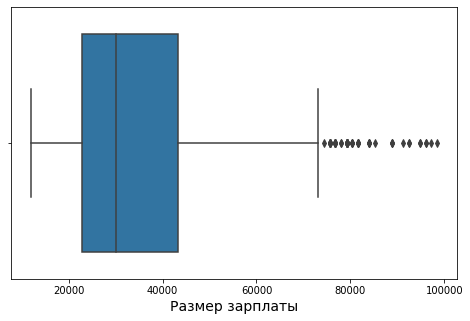

In [23]:
plt.figure(figsize=(8, 5))
analysis_chart = sns.boxplot(x = train_job_satisfaction_rate['salary'])

analysis_chart.set_xlabel('Размер зарплаты', fontsize=14);

Среди значений зарплаты значительное число выбросов, они являются важной частью датасета, поэтому сохраним их. Нормализируем или стандартизируем численный признак в зависимости от влияния на точность модели.

Распределение признака напоминает распределние Пуассона.

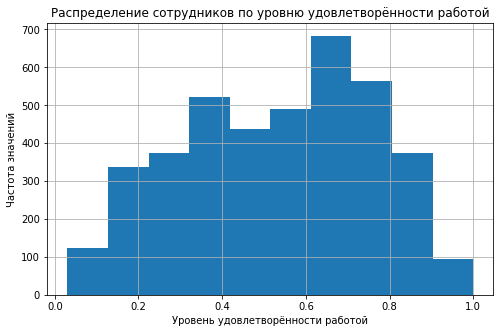

In [24]:
analysis_chart = train_job_satisfaction_rate['job_satisfaction_rate'].plot(
    y = 'job_satisfaction_rate',
    kind = 'hist',
    bins = 10,
    grid = True,
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню удовлетворённости работой',
)
analysis_chart.set_xlabel("Уровень удовлетворённости работой")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

Признак распределён неравномерно.

In [25]:
display(test_features.info())
display(test_features.drop('id', axis=1).describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


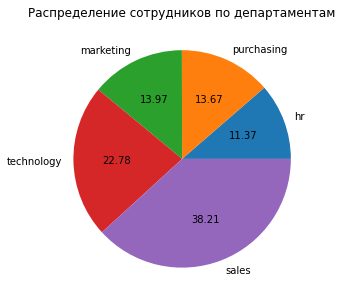

In [26]:
analysis_chart = test_features.groupby('dept')['id'].count().sort_values().plot(
    y = 'dept',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по департаментам',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак dept при помощи OneHotEncoder. Пропуски заполняем при помощи SimpleInputer.

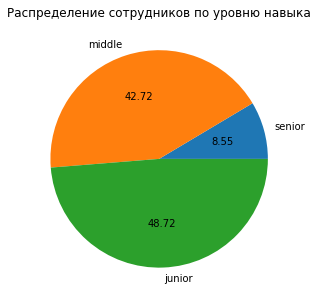

In [27]:
analysis_chart = test_features.groupby('level')['id'].count().sort_values().plot(
    y = 'level',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню навыка',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак level при помощи OrdinalEncoder. Пропуски заполняем при помощи SimpleInputer.

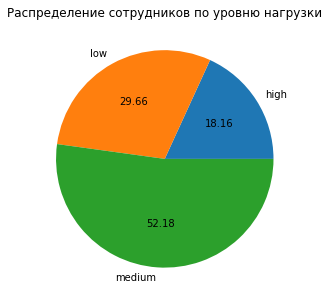

In [28]:
analysis_chart = test_features.groupby('workload')['id'].count().sort_values().plot(
    y = 'workload',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню нагрузки',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак workload при помощи OrdinalEncoder. Пропуски заполняем при помощи SimpleInputer.

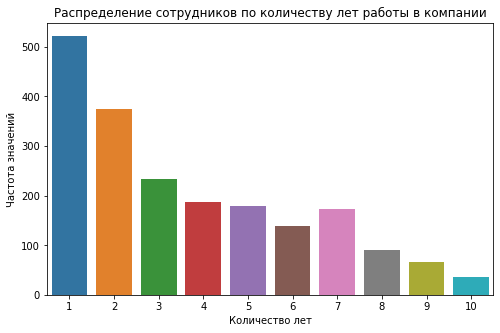

In [29]:
plt.figure(figsize=(8, 5))

analysis_chart = sns.countplot(x = test_features['employment_years'])

analysis_chart.set_title("Распределение сотрудников по количеству лет работы в компании")
analysis_chart.set_xlabel("Количество лет")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

Распределение признака напоминает распределние Пуассона.

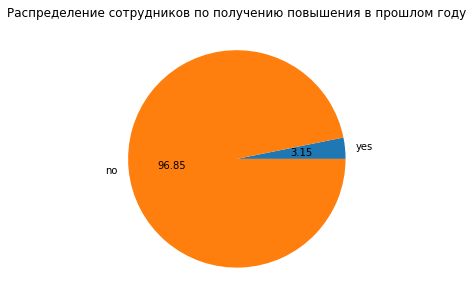

In [30]:
analysis_chart = test_features.groupby('last_year_promo')['id'].count().sort_values().plot(
    y = 'last_year_promo',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по получению повышения в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак при помощи OrdinalEncoder.

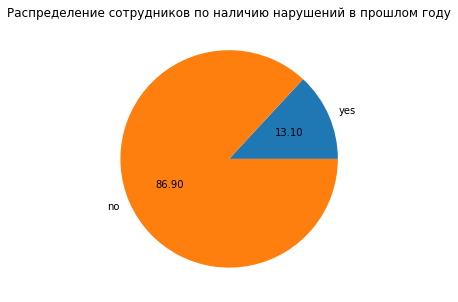

In [31]:
analysis_chart = test_features.groupby('last_year_violations')['id'].count().sort_values().plot(
    y = 'last_year_violations',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по наличию нарушений в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак при помощи OrdinalEncoder.

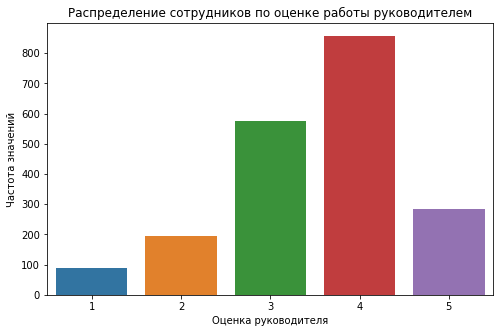

In [32]:
plt.figure(figsize=(8, 5))

analysis_chart = sns.countplot(x = test_features['supervisor_evaluation'])

analysis_chart.set_title("Распределение сотрудников по оценке работы руководителем")
analysis_chart.set_xlabel("Оценка руководителя")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

Признак распределён неравномерно.

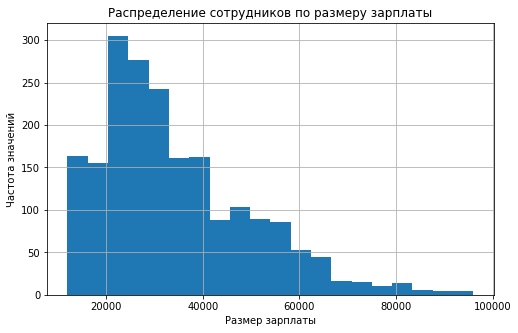

In [33]:
analysis_chart = test_features['salary'].plot(
    y = 'salary',
    kind = 'hist',
    bins = 20,
    grid = True,
    figsize = (8, 5),
    title = 'Распределение сотрудников по размеру зарплаты',
)
analysis_chart.set_xlabel("Размер зарплаты")
analysis_chart.set_ylabel("Частота значений");

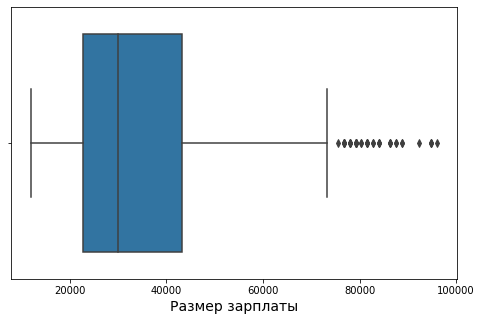

In [34]:
plt.figure(figsize=(8, 5))
analysis_chart = sns.boxplot(x = test_features['salary'])

analysis_chart.set_xlabel('Размер зарплаты', fontsize=14);

Среди значений зарплаты значительное число выбросов, они являются важной частью датасета, поэтому сохраним их. Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели.

Распределение признака напоминает распределние Пуассона.

In [35]:
display(test_target_job_satisfaction_rate.info())
display(test_target_job_satisfaction_rate.drop('id', axis=1).describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


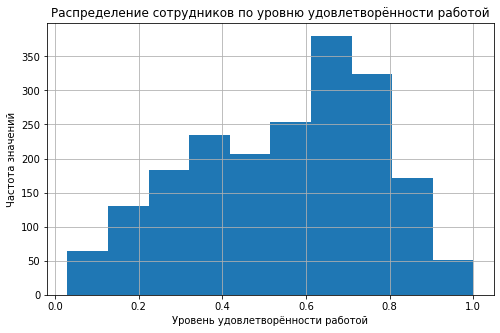

In [36]:
analysis_chart = test_target_job_satisfaction_rate['job_satisfaction_rate'].plot(
    y = 'job_satisfaction_rate',
    kind = 'hist',
    bins = 10,
    grid = True,
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню удовлетворённости работой',
)
analysis_chart.set_xlabel("Уровень удовлетворённости работой")
analysis_chart.set_ylabel("Частота значений");

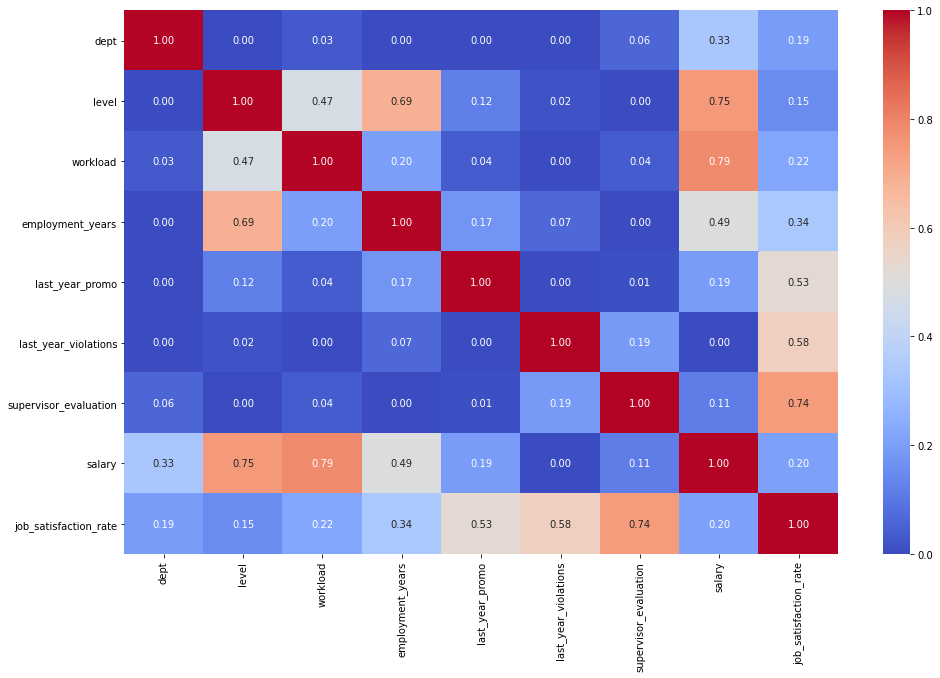

In [37]:
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']
plt.figure(figsize=(16, 10))
analysis_chart = sns.heatmap(
    test_features.merge(test_target_job_satisfaction_rate, on='id', how='inner').drop('id', axis=1).phik_matrix(interval_cols=num_columns), 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm'
);

## Подготовка данных

Продолжим предобработку. Создадим новую таблицу с тестовыми данными, чтобы сопоставить таблицы **test_features** и **test_target_job_satisfaction_rate** по *id*.

In [38]:
RANDOM_STATE = 42

Удалим признак *id* и проверим наличие дубликатов.

In [39]:
train_noid = train_job_satisfaction_rate.drop('id', axis=1)
print(train_noid.duplicated().sum())

245


Обнаружено 245 дубликатов. Удалим их.

In [40]:
train_noid = train_noid.drop_duplicates()
print(train_noid.duplicated().sum())

# print(train_job_satisfaction_rate_noid.index)
train_job_satisfaction_rate = train_job_satisfaction_rate.loc[train_noid.index]
print(train_job_satisfaction_rate.drop('id', axis=1).duplicated().sum())

0
0


Дубликаты удалены.

In [41]:
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate', 'id'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [42]:
display(test_features)
display(test_target_job_satisfaction_rate)

df_test = test_features.merge(test_target_job_satisfaction_rate, on='id', how='inner')
display(df_test)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
...,...,...
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [43]:
X_test = df_test.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = df_test['job_satisfaction_rate']

Создаём списки с названиями признаков.

In [44]:
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Создаём пайплайн для подготовки признаков из списка ohe_columns и ord_columns: OHE-кодирование и Ordinal-кодирование.

Порядок для признаков с Ordinal-кодированием:
* level: junior < middle < senior
* workload: low < medium < high
* last_year_promo: no < yes
* last_year_violations: yes < no

Создаём общий пайплайн предобработки.

In [45]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['yes', 'no']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
    ],
    remainder='passthrough'
)

## Обучение моделей

Создадим пользовательскую метрику SMAPE.

In [46]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2))

smape_scorer = make_scorer(smape, greater_is_better=False)

Создаём итоговый пайплайн: подготовка данных и модель.

Используем дерево *DecisionTreeRegressor* и модели регрессии *SVR* и *LinearRegression*. Подбираем для них гиперпараметры в сетке.

In [47]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [48]:
param_grid = [   
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split' : range(2, 5),
        'models__min_samples_leaf' : range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVR()
    {
        'models': [SVR()],
        # 'models__degree': range(1, 5),
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

search = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
best_params = search.best_params_

In [49]:
print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', -1 * search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

In [50]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

dummy_reg = DummyRegressor()
dummy_reg.fit(X_train_transformed, y_train)
y_test_pred_dummy = dummy_reg.predict(X_test_transformed)

dummy_test = smape(y_test, y_test_pred_dummy)

In [51]:
y_test_pred = best_model.predict(X_test)
smape_test = smape(y_test, y_test_pred)

if smape_test > dummy_test:
    print(f'Значение метрики SMAPE на модели-болванке {dummy_test} показывает лучший результат.')
else:
    print(f'Значение метрики SMAPE на подобранной модели {smape_test} показывает лучший результат.')

if smape_test > 15:
    print(f'Значение метрики SMAPE {smape_test} не удовлетворяет критерию успеха.')
else:
    print(f'Значение метрики SMAPE {smape_test} удовлетворяет критерию успеха.')

Значение метрики SMAPE на подобранной модели 13.737452806627665 показывает лучший результат.
Значение метрики SMAPE 13.737452806627665 удовлетворяет критерию успеха.


## Оформление выводов

Лучше всего показала себя модель SVR - регрессия опорных векторов. Разберём почему она оказалась лучше линейной регрессии и дерева регрессии.

Из матрицы выше видим, что целевой признак значительней всего коррелирует с четырьмя входными:
* employment_years
* last_year_promo
* last_year_violations
* supervisor_evaluation

Из них категориальными являются два признака: *last_year_promo* и *last_year_violations*.

Наиболее важным признаком является *supervisor_evaluation*. Модель SVR является более робастной в сравнении с LinearRegression, поэтому она может обнаружить выбросы - низкие значения признака *supervisor_evaluation*, позволяющие сделать вывод о низкой удовлетворённости работника.

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [53]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

## Предобработка данных

In [54]:
display(train_quit.info())
display(train_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [55]:
display(test_features.info())
display(test_features.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [56]:
display(test_target_quit.info())
display(test_target_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [57]:
print(train_job_satisfaction_rate.columns)
print(test_features.columns)
print(test_target_job_satisfaction_rate.columns)

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')
Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')
Index(['id', 'job_satisfaction_rate'], dtype='object')


В данных обнаружено незначительное количество пропусков. Пропуски находятся в важных категориальных колонках, без которых данные значительно теряют в ценности, поэтому в пайплайне будем их заполнять при помощи SimpleInputer. Все типы данных соответствуют истине.

Проверим наличие дубликатов.

In [58]:
print(train_quit.duplicated().sum())
print(test_features.duplicated().sum())
print(test_target_quit.duplicated().sum())

0
0
0


Явных дубликатов нет, проверим наличие неявных.

In [59]:
print(train_quit['dept'].unique())
print(train_quit['level'].unique())
print(train_quit['workload'].unique())
print(train_quit['last_year_promo'].unique())
print(train_quit['last_year_violations'].unique(), '\n')

print(test_features['dept'].unique())
print(test_features['level'].unique())
print(test_features['workload'].unique())
print(test_features['last_year_promo'].unique())
print(test_features['last_year_violations'].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes'] 

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


В данных обнаружены необработанные пропуски и опечатки. Обработаем их.

In [60]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan

train_quit.loc[train_quit['level'] == 'sinior', 'level'] = 'senior'
test_features.loc[test_features['level'] == 'sinior', 'level'] = 'senior'

In [61]:
print(test_features['dept'].unique())
print(test_features['workload'].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


In [62]:
print(train_quit.duplicated().sum())
print(test_features.duplicated().sum())
print(test_target_quit.duplicated().sum())

0
0
0


Дубликатов нет. Дальнейшая предобработка будет выполнена в пайплайне.

## Исследовательский анализ данных

In [63]:
display(train_quit.info())
display(train_quit.drop('id', axis=1).describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


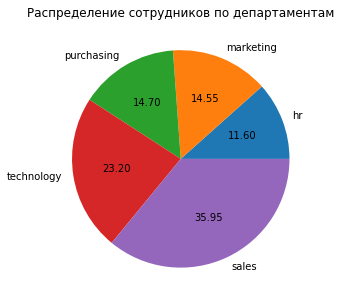

In [64]:
analysis_chart = train_quit.groupby('dept')['id'].count().sort_values().plot(
    y = 'dept',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по департаментам',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак dept при помощи OneHotEncoder. Пропуски заполняем при помощи SimpleInputer.

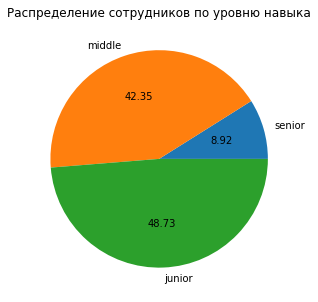

In [65]:
analysis_chart = train_quit.groupby('level')['id'].count().sort_values().plot(
    y = 'level',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню навыка',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак level при помощи OrdinalEncoder. Пропуски заполняем при помощи SimpleInputer.

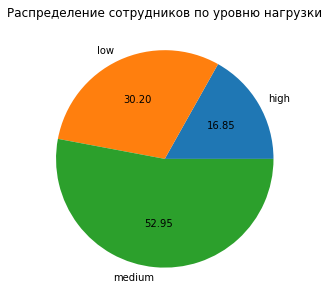

In [66]:
analysis_chart = train_quit.groupby('workload')['id'].count().sort_values().plot(
    y = 'workload',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по уровню нагрузки',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак workload при помощи OrdinalEncoder.

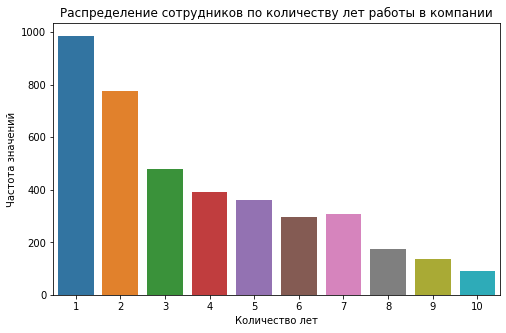

In [67]:
plt.figure(figsize=(8, 5))

analysis_chart = sns.countplot(x = train_quit['employment_years'])

analysis_chart.set_title("Распределение сотрудников по количеству лет работы в компании")
analysis_chart.set_xlabel("Количество лет")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

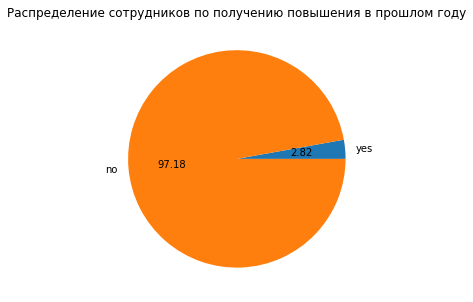

In [68]:
analysis_chart = train_quit.groupby('last_year_promo')['id'].count().sort_values().plot(
    y = 'last_year_promo',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по получению повышения в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак при помощи OrdinalEncoder.

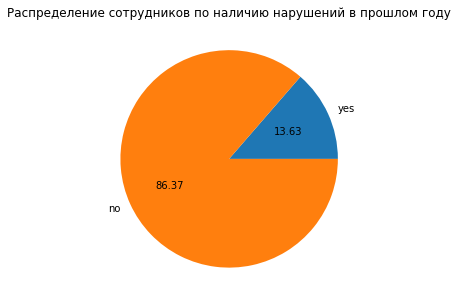

In [69]:
analysis_chart = train_quit.groupby('last_year_violations')['id'].count().sort_values().plot(
    y = 'last_year_violations',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по наличию нарушений в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак при помощи OrdinalEncoder.

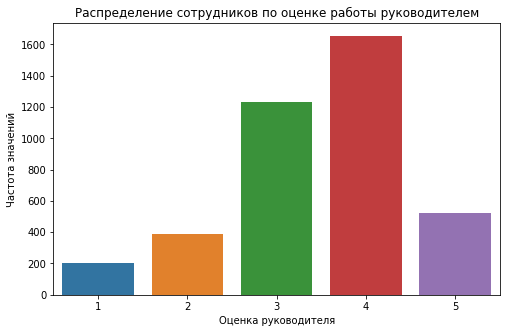

In [70]:
plt.figure(figsize=(8, 5))

analysis_chart = sns.countplot(x = train_quit['supervisor_evaluation'])

analysis_chart.set_title("Распределение сотрудников по оценке работы руководителем")
analysis_chart.set_xlabel("Оценка руководителя")
analysis_chart.set_ylabel("Частота значений");

Нормализируем или стандартизиуем численный признак в зависимости от влияния на точность модели. Возможно, стоит, категоризировать признак, однако, в численном виде он даст модели больше вариативности при анализе.

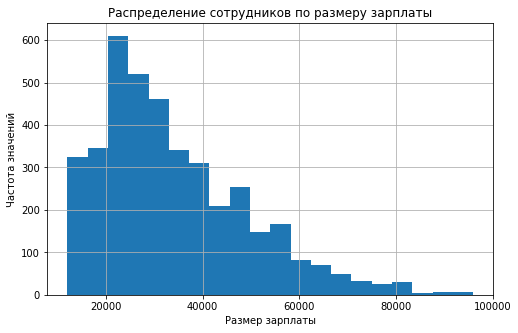

In [71]:
analysis_chart = train_quit['salary'].plot(
    y = 'salary',
    kind = 'hist',
    bins = 20,
    grid = True,
    figsize = (8, 5),
    title = 'Распределение сотрудников по размеру зарплаты',
)
analysis_chart.set_xlabel("Размер зарплаты")
analysis_chart.set_ylabel("Частота значений");

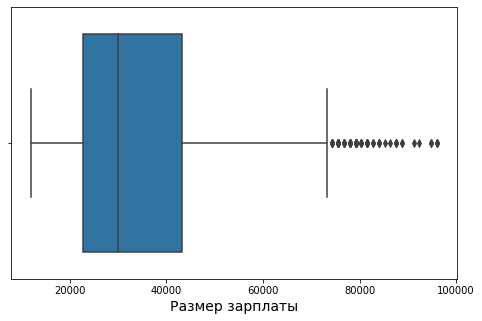

In [72]:
plt.figure(figsize=(8, 5))
analysis_chart = sns.boxplot(x = train_quit['salary'])

analysis_chart.set_xlabel('Размер зарплаты', fontsize=14);

Среди значений зарплаты значительное число выбросов, они являются важной частью датасета, поэтому сохраним их. Нормализируем или стандартизируем численный признак в зависимости от влияния на точность модели.

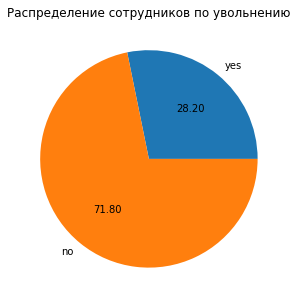

In [73]:
analysis_chart = train_quit.groupby('quit')['id'].count().sort_values().plot(
    y = 'quit',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение сотрудников по увольнению',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Таблица *test_features* уже была изучена в задаче №1.

Создадим портрет медианного уволившегося сотрудника.

In [74]:
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [75]:
train_quit_true = train_quit[train_quit['quit'] == 'yes']

quit_dept = train_quit_true.groupby('dept')['dept'].count().sort_values(ascending=False).index[0]
quit_level = train_quit_true.groupby('level')['level'].count().sort_values(ascending=False).index[0]
quit_workload = train_quit_true.groupby('workload')['workload'].count().sort_values(ascending=False).index[0]
quit_promo = train_quit_true.groupby('last_year_promo')['last_year_promo'].count().sort_values(ascending=False).index[0]
quit_viol = train_quit_true.groupby('last_year_violations')['last_year_violations'].count().sort_values(ascending=False).index[0]
quit_years = train_quit_true['employment_years'].median()
quit_eval = train_quit_true['supervisor_evaluation'].median()
quit_salary = train_quit_true['salary'].median()
median_salary = train_quit['salary'].median()

print(f'Больше всего уволившихся из департамента {quit_dept}, увольняются обычно сотрудники с уровнем "{quit_level}" и {quit_workload} нагрузкой.')
print(f'Наличие повышения в прошлом году у большинства уволившихся сотрудников - {quit_promo}.')
print(f'Наличие нарушений в прошлом году у большинства уволившихся сотрудников - {quit_viol}.')
print(f'Медианный уволившийся сотрудник работал в компании {quit_years} лет. Руководитель оценивал такого сотрудника на {quit_eval} баллов.')
print(f'Медианная зарплата уволившегося сотрудника - {quit_salary}. Медианная зарплата по компании - {median_salary}')

Больше всего уволившихся из департамента sales, увольняются обычно сотрудники с уровнем "junior" и low нагрузкой.
Наличие повышения в прошлом году у большинства уволившихся сотрудников - no.
Наличие нарушений в прошлом году у большинства уволившихся сотрудников - no.
Медианный уволившийся сотрудник работал в компании 1.0 лет. Руководитель оценивал такого сотрудника на 3.0 баллов.
Медианная зарплата уволившегося сотрудника - 22800.0. Медианная зарплата по компании - 30000.0


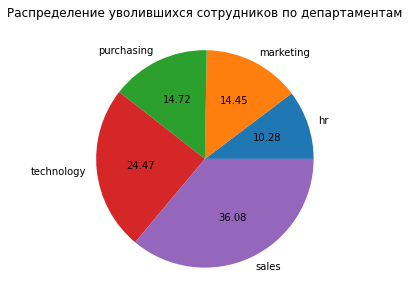

In [76]:
analysis_chart = train_quit_true.groupby('dept')['id'].count().sort_values().plot(
    y = 'dept',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение уволившихся сотрудников по департаментам',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Кодируем признак dept при помощи OneHotEncoder. Пропуски заполняем при помощи SimpleInputer.

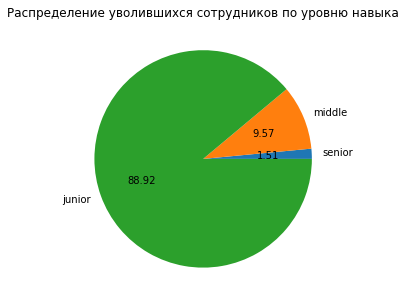

In [77]:
analysis_chart = train_quit_true.groupby('level')['id'].count().sort_values().plot(
    y = 'level',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение уволившихся сотрудников по уровню навыка',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

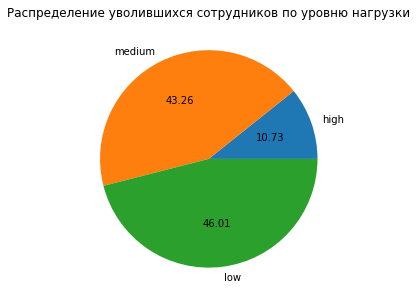

In [78]:
analysis_chart = train_quit_true.groupby('workload')['id'].count().sort_values().plot(
    y = 'workload',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение уволившихся сотрудников по уровню нагрузки',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

In [79]:
print(train_quit_true['employment_years'].value_counts(normalize=True))

1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64


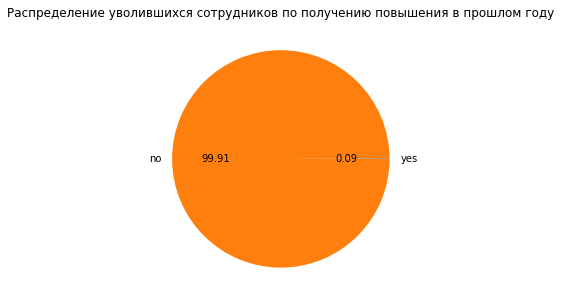

In [80]:
analysis_chart = train_quit_true.groupby('last_year_promo')['id'].count().sort_values().plot(
    y = 'last_year_promo',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение уволившихся сотрудников по получению повышения в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

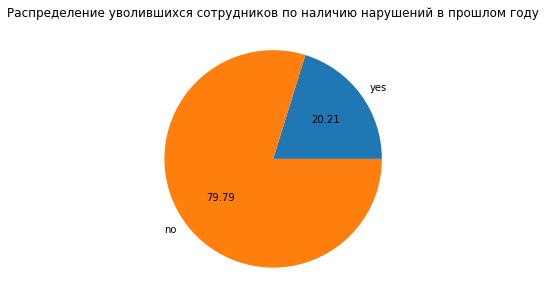

In [81]:
analysis_chart = train_quit_true.groupby('last_year_violations')['id'].count().sort_values().plot(
    y = 'last_year_violations',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение уволившихся сотрудников по наличию нарушений в прошлом году',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

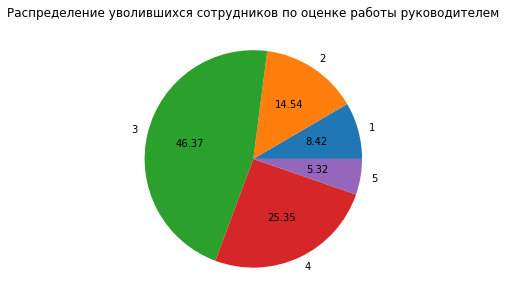

In [82]:
analysis_chart = train_quit_true.groupby('supervisor_evaluation')['id'].count().sort_index().plot(
    y = 'supervisor_evaluation',
    kind = 'pie',
    figsize = (8, 5),
    title = 'Распределение уволившихся сотрудников по оценке работы руководителем',
    autopct='%.2f',
)
analysis_chart.set_ylabel("");

Изучим зависимость между *job_satisfaction_rate* и уходом сотрудника из компании. Для этого спронозируем *job_satisfaction_rate* для таблицы *train_quit*, используя полученную в прошлой задаче модель.

In [83]:
test_features_united = test_features.merge(test_target_job_satisfaction_rate, on='id')
test_features_united = test_features_united.merge(test_target_quit, on='id')

display(test_features_united)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.14,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.11,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.43,no


Сравним *job_satisfaction_rate* у уволившихся сотрудников и у оставшихся.

In [84]:
test_features_united_true = test_features_united[test_features_united['quit'] == 'yes']

quit_satisfaction = test_features_united_true['job_satisfaction_rate'].median()
median_satisfaction = test_features_united['job_satisfaction_rate'].median()

print(f'Уровень удовлетворённости работой у уволившихся сотрудников - {quit_satisfaction}.')
print(f'Уровень удовлетворённости работой у оставшихся сотрудников - {median_satisfaction}.')

Уровень удовлетворённости работой у уволившихся сотрудников - 0.37.
Уровень удовлетворённости работой у оставшихся сотрудников - 0.58.


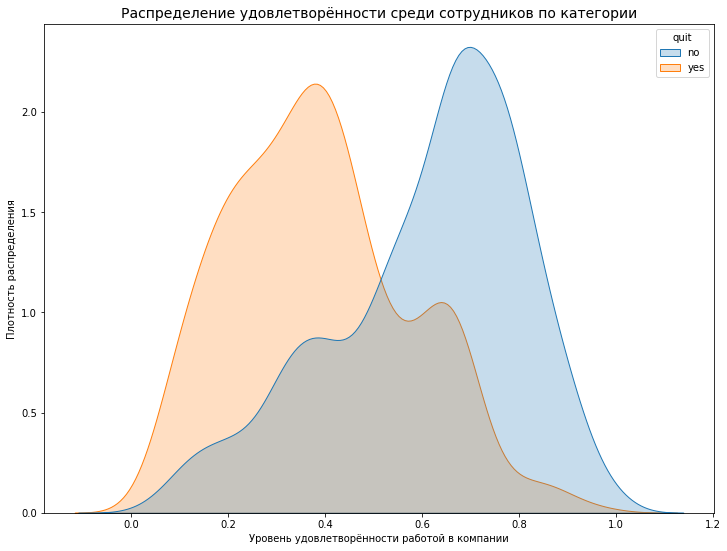

In [85]:
plt.figure(figsize=(12, 9))

analysis_chart = sns.kdeplot(
    data = test_features_united,
    x = 'job_satisfaction_rate',
    hue='quit',
    shade=True,
    common_norm=False
)

analysis_chart.set_title('Распределение удовлетворённости среди сотрудников по категории', fontsize=14)
analysis_chart.set_xlabel("Уровень удовлетворённости работой в компании")
analysis_chart.set_ylabel("Плотность распределения");

Из графика выше можно сделать вывод о зависимости уровня удовлетворённости сотрудника работой и шансом увольнения сотрудника, поскольку в верхней гистограмме значительно более низкий уровень сотрудников с удовлетворённостью более 0.5.

## Добавление нового входного признака

Добавляем входной признак *job_satisfaction_rate* в таблицы **train_quit** и **test_features**.

In [86]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)
display(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.574303
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.829847
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.308948
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.269278
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.720174
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.563056
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.768795
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.457987
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.505138


In [87]:
test_features['job_satisfaction_rate'] = best_model.predict(test_features)
display(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.791971
1,686555,hr,junior,medium,1,no,no,4,30000,0.700409
2,467458,sales,middle,low,5,no,no,4,19200,0.616264
3,418655,sales,middle,low,6,no,no,4,19200,0.658113
4,789145,hr,middle,medium,5,no,no,5,40800,0.676805
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.559699
1996,109582,technology,middle,low,3,no,no,2,21600,0.122481
1997,305653,technology,junior,low,1,no,no,3,14400,0.201008
1998,160233,technology,middle,low,8,no,no,1,32400,0.561050


Успешно.

## Подготовка данных

In [88]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = train_quit.drop(['quit', 'id'], axis=1)
y_train = train_quit['quit']

display(test_features)
display(test_target_quit)

df_test = test_features.merge(test_target_quit, on='id')
display(df_test)

X_test = df_test.drop(['quit', 'id'], axis=1)
y_test = df_test['quit']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.791971
1,686555,hr,junior,medium,1,no,no,4,30000,0.700409
2,467458,sales,middle,low,5,no,no,4,19200,0.616264
3,418655,sales,middle,low,6,no,no,4,19200,0.658113
4,789145,hr,middle,medium,5,no,no,5,40800,0.676805
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.559699
1996,109582,technology,middle,low,3,no,no,2,21600,0.122481
1997,305653,technology,junior,low,1,no,no,3,14400,0.201008
1998,160233,technology,middle,low,8,no,no,1,32400,0.561050


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.791971,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.700409,no
2,467458,sales,middle,low,5,no,no,4,19200,0.616264,no
3,418655,sales,middle,low,6,no,no,4,19200,0.658113,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.676805,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.559699,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.122481,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.201008,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.561050,no


['no' 'yes']


Создаём списки с названиями признаков.

In [89]:
ohe_columns = ['dept']
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Создаём пайплайн для подготовки признаков из списка ohe_columns и ord_columns: OHE-кодирование и Ordinal-кодирование.

Порядок для признаков с Ordinal-кодированием:
* level: junior < middle < senior
* workload: low < medium < high
* last_year_promo: no < yes
* last_year_violations: yes < no

Создаём общий пайплайн предобработки.

In [90]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['yes', 'no']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
    ],
    remainder='passthrough'
)

## Обучение модели

Создаём итоговый пайплайн: подготовка данных и модель.

Используем дерево *DecisionTreeClassifier*, модели регрессии *SVC* и *LogisticRegression* и модель *kNN*. Подбираем для них гиперпараметры в сетке.

In [91]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [   
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split' : range(2, 5),
        'models__min_samples_leaf' : range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
]

search = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    # random_state=RANDOM_STATE,
    n_jobs=-1,
)

search.fit(X_train, y_train)

best_model_quit = search.best_estimator_
best_params_quit = search.best_params_

In [92]:
print('Лучшая модель и её параметры:\n\n', best_model_quit)
print ('Метрика лучшей модели на тренировочной выборке:', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                           

In [93]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

dummy_class = DummyClassifier(random_state=RANDOM_STATE)
dummy_class.fit(X_train_transformed, y_train)
y_test_pred_dummy = dummy_class.predict_proba(X_test_transformed)[:,1]

dummy_test = roc_auc_score(y_test, y_test_pred_dummy)

In [94]:
y_test_pred = best_model_quit.predict_proba(X_test)[:,1]
roc_auc_test = roc_auc_score(y_test, y_test_pred)

if roc_auc_test < dummy_test:
    print(f'Значение метрики ROC-AUC на модели-болванке {dummy_test} показывает лучший результат.')
else:
    print(f'Значение метрики ROC-AUC на подобранной модели {roc_auc_test} показывает лучший результат.')

if roc_auc_test < 0.91:
    print(f'Значение метрики ROC-AUC {roc_auc_test} не удовлетворяет критерию успеха.')
else:
    print(f'Значение метрики ROC-AUC {roc_auc_test} удовлетворяет критерию успеха.')

Значение метрики ROC-AUC на подобранной модели 0.9260128360892155 показывает лучший результат.
Значение метрики ROC-AUC 0.9260128360892155 удовлетворяет критерию успеха.


## Выводы

Проанализируем результаты перед выводом.

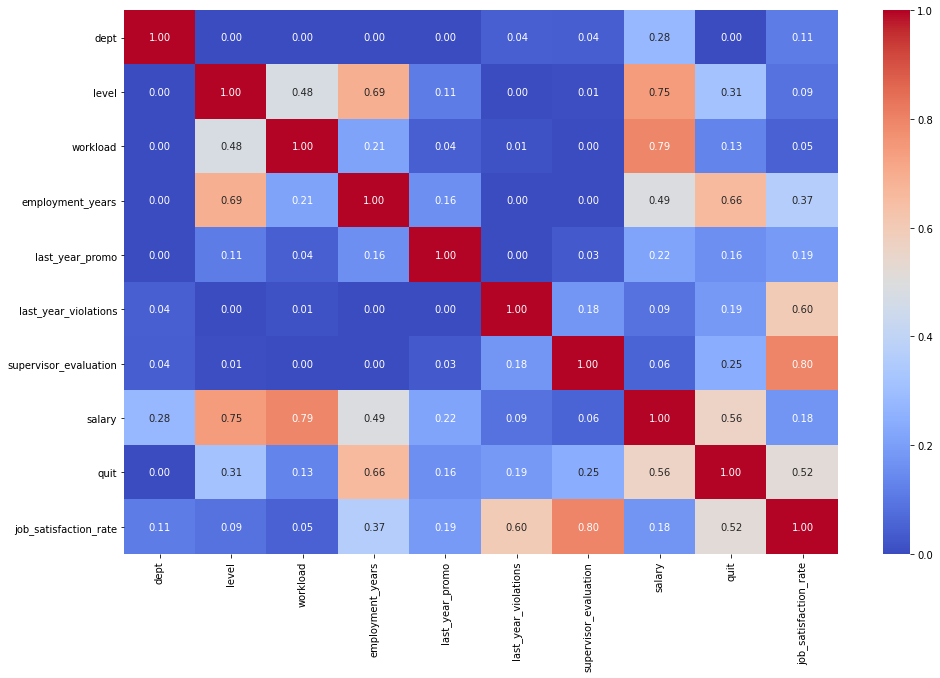

In [95]:
plt.figure(figsize=(16, 10))
analysis_chart = sns.heatmap(
    train_quit.drop('id', axis=1).phik_matrix(interval_cols=num_columns), 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm'
);

Уход сотрудника в наибольшей степени кореллирует с тремя входными признаками:
* *employment_years*
* *salary*
* *job_satisfaction_rate*

Все эти признаки являются численными, значит, дерево решений будет хуже справляться с прогнозом. В числовых признаках *employment_years* и *salary* много выбросов, поэтому логистическая регрессия справится хуже. Модель SVC хорошо работает при этих условиях, поэтому она и показала лучший результат в этой задаче.

# Общий вывод

Данные, предоставленные компанией, имели ряд незначительных ошибок и неточностей. В данных для обеих задач были заполнены пропуски и были исправлены опечатки.

При решении первой задачи были использованы модели *DecisionTreeRegressor*, *SVR* и *LinearRegression* и пользовательская метрика *SMAPE*.

Лучшие результаты из них показала модель *SVR*. Для неё были подобраны гиперпараметры и вычислена метрика. Значение метрики на тестовой выборке - **13.567**.

Для второй задачи необходимое значение столбца *job_satisfaction_rate* было вычисленно при помощи определённой в первой задаче лучшей модели. При решении второй задачи были использованы модели *DecisionTreeClassifier*, *SVC*, *LogisticRegression* и *kNN* и метрика *ROC-AUC*.

Лучшие результаты из них показала модель *SVC*. Для неё были подобраны гиперпараметры и вычислена метрика. Значение метрики на тестовой выборке - **0.926**.

Портрет медианного уволившегося сотрудника: сотрудник из департамента продаж, с уровнем "junior" и низкой нагрузкой. В прошлом году у такого сотрудника не было ни повышений, ни нарушений. Этот человек работал в компании один год. Руководитель оценивал такого сотрудника на 3 балла из 10. Медианная зарплата уволившегося сотрудника - 22800, в то время как медианная зарплата по компании - 30000.

Уход таких сотрудников не должен нанести ощутимого ущерба производительности компании в связи с их низким уровнем квалификации и малой вовлечённостью в работу компании, которой и объясняется низкий уровень зарплаты таких сотрудников. Малая продолжительность работы в компании свидетельствует о незаинтересованности уволившихся в продолжении деятельности и развитии своих навыков в компании.

Считаю наиболее рациональным решением сконцентрировать усилия на удержании меньшинства наиболее квалифицированных сотрудников повышениями в должности и зарплате. Если цель состоит в удержании медианного сотрудника от увольнения, то таким стоит предложить курсы по повышению квалификации за счёт компании и возможности увеличения нагрузки для продвижения к повышению.